In [1]:
# здесь всё предустановлено должно быть
import pandas as pd
import numpy as np
import scipy.stats as st

import json
import _pickle as pickle

from copy import deepcopy

from matplotlib import pyplot as plt

from scipy.spatial.distance import euclidean

In [2]:
# импортируем нужную функцию
from tqdm import tqdm

In [5]:
data = pd.read_csv('28082020.csv',sep = ';' ,low_memory=False, dtype = str)

In [7]:
data = data.iloc[3:]

In [9]:
data = data.iloc[3:]

In [11]:
data.rename(columns={
    "Contact ID": "user_id",
    "Cheque ID": "bill_id",
    "Sale Date ID": "timestamp",
    "Quantity":"bill_product_count",
    "Price":"bill_product_price",
    "Discount Value":"discount_amount",
    "Product ID":"product_code"
}, inplace=True)

In [12]:
data = data[["user_id", "product_code", "bill_id", "timestamp",
                           "bill_product_count", "bill_product_price", "discount_amount"]]

In [13]:
data['bill_product_count'] = data['bill_product_count'].astype(float)
data['bill_product_price'] = data['bill_product_price'].astype(float)
data['discount_amount'] = data['discount_amount'].astype(float)
 

In [14]:
app_opens = pd.read_csv("2600-2900 app.csv",sep = ';',dtype = str)

In [15]:
app_opens.rename(columns={
    "Contact ID": "user_id",
    "Unnamed: 1": "app_open"
}, inplace=True)

In [16]:
app_opens['app_open'] = app_opens['app_open'].astype(int)

In [17]:
app_opens_dict = app_opens.groupby("user_id").app_open.sum().to_dict()

In [18]:
# тут 45 тысяч нужных покупателей
ab_users = pd.read_csv("splited_users.csv",sep = ',',dtype = str)

In [20]:
ab_users.rename(columns={
    "Contact ID": "user_id",
}, inplace=True)

In [22]:
ndata = data[data.user_id.isin(ab_users.user_id.values)]

In [23]:
ndata = ndata.sort_values("timestamp")

In [24]:
needed_data = ndata[["user_id", "product_code", "bill_id", "timestamp",
                           "bill_product_count", "bill_product_price", "discount_amount"]]

In [25]:
needed_data["discount_amount"] = needed_data["discount_amount"].fillna(0)

In [26]:
needed_data["bill_real_price"] = needed_data["bill_product_price"] * needed_data["bill_product_count"] - needed_data["discount_amount"]

In [28]:
# отрежем датасет от этого индекса до конца выгрузки
needed_data = needed_data[needed_data["timestamp"] >= "2019-10-30T00:00:00"]

In [29]:
needed_data.user_id.nunique()

28401

In [30]:
#едём dictionary, где для каждого клиента будем хранить его медианный чек, количество визитов, средний отклик на коммуникацию и медианную маржу на чек (надо добавить)
user_rfo = {}


for user, group in tqdm(needed_data.groupby('user_id')):
    bill_prices = group.groupby("bill_id").bill_real_price.sum().values.tolist()

    if len(bill_prices) == 0:
        bill_prices.append(0)

    user_rfo[user] = (
        np.mean(bill_prices),
        group.bill_id.nunique(),
        group[group["discount_amount"] > 0].shape[0] / group.shape[0],
        app_opens_dict.get(user, 0)
    )

100%|██████████| 28401/28401 [00:53<00:00, 529.60it/s]


# Выведем графики по каждой переменной

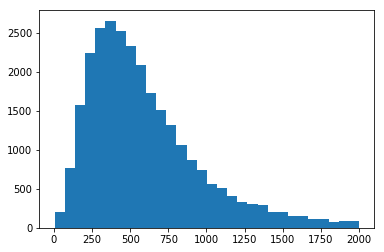

In [31]:
plt.hist(list(filter(lambda x: x < 2000, [user_rfo[key][0] for key in user_rfo.keys()])), 30)
plt.show()

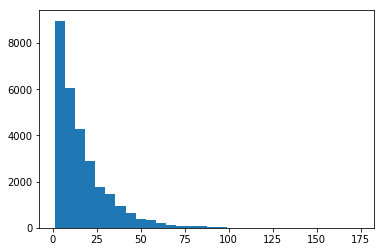

In [32]:
plt.hist(list(filter(lambda x: x < 500, [user_rfo[key][1] for key in user_rfo.keys()])), 30)
plt.show()

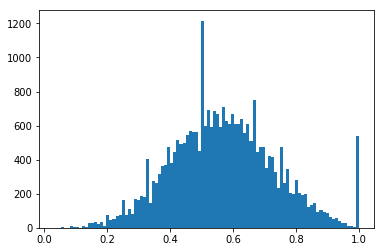

In [33]:
plt.hist(list(filter(lambda x: x, [user_rfo[key][2] for key in user_rfo.keys()])), 100)
plt.show()

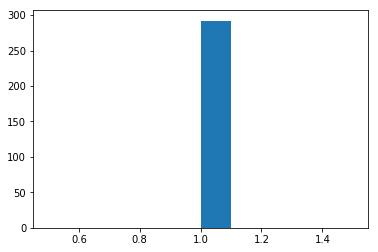

In [34]:
plt.hist(list(filter(lambda x: x, [user_rfo[key][3] for key in user_rfo.keys()])))
plt.show()

In [35]:
np.mean([user_rfo[key][3] for key in user_rfo.keys()])

0.010281328122249217

In [36]:
# итоговое количество клиентов, которых будем делить на две группы
len(user_rfo.keys())

28401

In [37]:
# нормируем параметры по людям
norm_user_rfo = {}

max_rev = np.max([user_rfo[user][0] for user in user_rfo.keys()])
max_freq = np.max([user_rfo[user][1] for user in user_rfo.keys()])
max_otkl = np.max([user_rfo[user][2] for user in user_rfo.keys()])
# max_marg = np.max([user_rfo[user][3] for user in user_rfo.keys()])

for user in user_rfo.keys():
    norm_user_rfo[user] = (
        user_rfo[user][0] / max_rev,
        user_rfo[user][1] * 1.0 / max_freq,
        user_rfo[user][2] / max_otkl,
        user_rfo[user][3]
        # ещё добавить для маржинальности
        # user_rfo[user][3] / max_marg
    )

In [38]:
# функция для нахождения k ближайших соседей в евклидовом пространстве
# obj - объект, для которого ищем
# users - среди кого ищем
# k - количество соседей
def find_k_closest(obj, users, k):
    all_users = list(users.keys())
    
    dists = []
    for user in all_users:
        dists.append(euclidean(obj, users[user]))
        
    best_inds = np.argsort(dists)[:k]
    closest_users = [all_users[i] for i in best_inds]

    return closest_users

In [39]:
# пример
find_k_closest((0.044589290053331801, 0.029411764705882353, 0.0, 0.0), norm_user_rfo, 5)

['181374', '96192', '9982', '86490', '216186']

In [41]:
# копируем наш dictionary в отдельную переменную
users = deepcopy(norm_user_rfo)

all_users = list(users.keys())
print(len(all_users))

k = 11

# заводим dictionary с id клиентов и их признаками, надо раскомментировать часть с маржинальностью
# делаем это для того, чтобы не возникало ошибок с проверкой на статзначимость на первых итерациях
groups = {
    'u1': [all_users[0], all_users[1]],
    'r1': [users[all_users[0]][0], users[all_users[1]][0]],
    'f1': [users[all_users[0]][1], users[all_users[1]][1]],
    'o1': [users[all_users[0]][2], users[all_users[1]][2]],
    'a1': [users[all_users[0]][3], users[all_users[1]][3]],
    'u2': [all_users[2], all_users[3]],
    'r2': [users[all_users[2]][0], users[all_users[3]][0]],
    'f2': [users[all_users[2]][1], users[all_users[3]][1]],
    'o2': [users[all_users[2]][2], users[all_users[3]][2]],
    'a2': [users[all_users[2]][3], users[all_users[3]][3]],
    'u3': [all_users[4], all_users[5]],
    'r3': [users[all_users[4]][0], users[all_users[5]][0]],
    'f3': [users[all_users[4]][1], users[all_users[5]][1]],
    'o3': [users[all_users[4]][2], users[all_users[5]][2]],
    'a3': [users[all_users[4]][3], users[all_users[5]][3]]
}

# удаляем клиентов, которых уже добавили
del users[all_users[0]]
del users[all_users[1]]
del users[all_users[2]]
del users[all_users[3]]
del users[all_users[4]]
del users[all_users[5]]

iterator = 0

# итерируемся по всем остальным
for u in tqdm(all_users[6:]):
#     на всякий случай - если клиент уже есть во второй группе, то пропускаем его
    if u in groups['u2'] or u in groups['u3']:
        continue
    
#     iterator += 1
    
#     добавляем идентификатор клиента и его параметры в словарь в первую группу
    groups['u1'].append(u)
    groups['r1'].append(user_rfo[u][0])
    groups['f1'].append(user_rfo[u][1])
    groups['o1'].append(user_rfo[u][2])
    groups['a1'].append(user_rfo[u][3])
    
    
    # выносим признаки клиента в отдельную переменную и удаляем его из словаря
    val = users[u]
    del users[u]
    
    closest_users = find_k_closest(val, users, k)
    
    # теперь считаем для каждого статзначимость признаков, после добавления кого-то конкретного во вторую группу
    pvalues = []
    for cu in closest_users:
        tmp_pr_1 = st.ttest_ind(groups['r1'], groups['r2'] + [user_rfo[cu][0]]).pvalue
        tmp_pf_1 = st.ttest_ind(groups['f1'], groups['f2'] + [user_rfo[cu][1]]).pvalue
        tmp_po_1 = st.ttest_ind(groups['o1'], groups['o2'] + [user_rfo[cu][2]]).pvalue
        tmp_pa_1 = st.ttest_ind(groups['a1'], groups['a2'] + [user_rfo[cu][3]]).pvalue
        tmp_sum_p_1 = tmp_pr_1 + tmp_pf_1 + tmp_po_1 + tmp_pa_1
    
        tmp_pr_2 = st.ttest_ind(groups['r1'], groups['r3'] + [user_rfo[cu][0]]).pvalue
        tmp_pf_2 = st.ttest_ind(groups['f1'], groups['f3'] + [user_rfo[cu][1]]).pvalue
        tmp_po_2 = st.ttest_ind(groups['o1'], groups['o3'] + [user_rfo[cu][2]]).pvalue
        tmp_pa_2 = st.ttest_ind(groups['a1'], groups['a3'] + [user_rfo[cu][3]]).pvalue
        tmp_sum_p_2 = tmp_pr_2 + tmp_pf_2 + tmp_po_2 + tmp_pa_2
        
        pvalues.append((tmp_sum_p_1, tmp_sum_p_2))
    
    # находим клиента, который лучше всего повышает суммарную статзначимость
    best_ind = np.argmax([tmp_p[0] for tmp_p in pvalues])
    best_user = closest_users[best_ind]
    
    # добавляем его во вторую группу
    groups['u2'].append(best_user)
    groups['r2'].append(user_rfo[best_user][0])
    groups['f2'].append(user_rfo[best_user][1])
    groups['o2'].append(user_rfo[best_user][2])
    groups['a2'].append(user_rfo[best_user][3])


    pvalues[best_ind] = (-1, -1)
    del users[best_user]
    
    
    best_ind = np.argmax([tmp_p[1] for tmp_p in pvalues])
    best_user = closest_users[best_ind]
    
    # добавляем его во вторую группу
    groups['u3'].append(best_user)
    groups['r3'].append(user_rfo[best_user][0])
    groups['f3'].append(user_rfo[best_user][1])
    groups['o3'].append(user_rfo[best_user][2])
    groups['a3'].append(user_rfo[best_user][3])

    del users[best_user]

28401



  1%|          | 309/28395 [02:40<4:28:54,  1.74it/s]


  1%|▏         | 361/28395 [03:05<3:07:51,  2.49it/s]

KeyboardInterrupt: 

In [ ]:
rev1 = needed_data[(needed_data.user_id.isin(ab_users[ab_users.group_type == "firt_group"].user_id.values))].bill_real_price.sum()
rev2 = needed_data[(needed_data.user_id.isin(ab_users[ab_users.group_type  == "second_group"].user_id.values))].bill_real_price.sum()
rev3 = needed_data[(needed_data.user_id.isin(ab_users[ab_users.group_type  == "control"].user_id.values))].bill_real_price.sum()

print(rev1 / rev2)
print(rev2 / rev3)
print(rev1 / rev3)


In [ ]:
test1 = pd.DataFrame(groups["u1"], columns=["user_id"])
test1["group_type"] = "firt_group"

test2 = pd.DataFrame(groups["u2"], columns=["user_id"])
test2["group_type"] = "second_group"

control = pd.DataFrame(groups["u3"], columns=["user_id"])
control["group_type"] = "control"


ab = pd.concat([test1, test2, control])
ab["last_communication_date"] = "-"
ab["user_segment"] = "default"

In [95]:
ab.to_csv("ab_splitted_users.csv", index=False)

In [96]:
grouped_users = pd.read_csv("ab_splitted_users.csv",sep = ',',dtype = str)